# Применение логистической регрессии для решения задачи классификации

# Описание набора данных

Данный набор содержит информацию о пассажирах корабля «Титаник», затонувшего в ночь на 15-е апреля 1912 года. Некоторое количество пассажиров спаслось, чему способствовало множество различных факторов, включая их пол, возраст, на какой палубе находилась их кабина, социальный статус, и т.д.

Набор данных состоит из различных признаков, описывающих информацию о пассажирах. Каждая строка таблицы — отдельный пассажир, вся информация о нем содержится в его строке. 

Описание датасета:
- **Survived** (целевой признак): выжил ли пассажир (0 = Нет, 1 = Да);
- **Pclass**: класс каюты (1 = 1st, 2 = 2nd, 3 = 3rd);
- **Sex**: пол (female или male)	
- **Age**: возраст в годах
- **SibSp**: количество братьев, сестёр (в том числе сводных) и супругов на борту	
- **Parch**: количество детей и родителей на борту
- **Ticket**: номер билета	
- **Fare**: стоимость проезда пассажира	
- **Cabin**: номер каюты	
- **Embarked**: порт посадки пассажира (C = Cherbourg, Q = Queenstown, S = Southampton).

Необходимо решить задачу классификации и научиться предсказывать целовой признак **Survived** — выживет ли пассажир — по соответсвующим ему нецелевым признакам.


# Подготовка и первичный анализ данных

In [65]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [66]:
data = pd.read_csv('titanic_train.csv')

In [67]:
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,3,1,"Smyth, Miss. Julia",female,NaN,0,0,335432,7.7333,NaN,Q,NaN
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q,"Co Clare, Ireland Washington, DC"
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,0,0,2688,7.2292,NaN,C,NaN
3,3,0,"Vovk, Mr. Janko",male,22.0,0,0,349252,7.8958,NaN,S,NaN
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,345778,9.5000,NaN,S,NaN


In [68]:
data.describe()

,pclass,survived,age,sibsp,parch,fare
count,981.000000,981.000000,782.000000,981.000000,981.000000,981.000000
mean,2.299694,0.382263,29.963448,0.480122,0.386340,32.517741
std,0.836593,0.486188,14.482025,0.989157,0.873987,49.306258
min,1.000000,0.000000,0.333300,0.000000,0.000000,0.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200


Установите количество пропущенных значений поля <code>age</code>:

In [69]:
data['age'].isna().sum()

199

Определите долю выживших

In [70]:
number_survived = data[data['survived']==1].shape[0]
total_passengers = data.shape[0]
percent_survived = number_survived/total_passengers
print(percent_survived)

0.382262996941896


Определите долю пропущенных значений в рамках каждого признака и избавьтесь от тех признаков, где доля пропусков больше трети. Также удалите колонку <code>ticket</code>, вряд ли эта информация будет полезной.

In [71]:
for feature in data.columns:
    number_missing_data = data[feature].isna().sum()
    percent_missing_data = number_missing_data/total_passengers
    if percent_missing_data > 1/3:
        print(feature, percent_missing_data)

cabin 0.7838939857288482
home.dest 0.42201834862385323


In [72]:
data.drop('cabin', axis=1, inplace=True)
data.drop('home.dest', axis=1, inplace=True)
data.drop('ticket', axis=1, inplace=True)

In [73]:
data.head()

,pclass,survived,name,sex,age,sibsp,parch,fare,embarked
0,3,1,"Smyth, Miss. Julia",female,NaN,0,0,7.7333,Q
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,0,0,7.7500,Q
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,0,0,7.2292,C
3,3,0,"Vovk, Mr. Janko",male,22.0,0,0,7.8958,S
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,9.5000,S


Из описания набора данных видно, что колонки <code>sibsp</code> и <code>parch</code> по сути отвечают за размер семьи. Замените эти две колонки на колонку <code>fam_size</code>, значения которой будут вычисляться как сумма соответствующих значений в колонках <code>sibsp</code> и <code>parch</code>. 

In [74]:
data['fam_size'] = data['sibsp'] + data['parch']
data.drop('sibsp', axis=1, inplace=True)
data.drop('parch', axis=1, inplace=True)
data

,pclass,survived,name,sex,age,fare,embarked,fam_size
0,3,1,"Smyth, Miss. Julia",female,NaN,7.7333,Q,0
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,7.7500,Q,0
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,7.2292,C,0
3,3,0,"Vovk, Mr. Janko",male,22.0,7.8958,S,0
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,9.5000,S,0
...,...,...,...,...,...,...,...,...
976,3,1,"Howard, Miss. May Elizabeth",female,NaN,8.0500,S,0
977,3,1,"Dorking, Mr. Edward Arthur",male,19.0,8.0500,S,0
978,2,0,"Gillespie, Mr. William Henry",male,34.0,13.0000,S,0
979,3,0,"Barton, Mr. David John",male,22.0,8.0500,S,0


In [75]:
num_male = data.loc[data['sex']=='male'].shape[0]

In [76]:
fam_size_mean = data['fam_size'].mean()
print(fam_size_mean)

0.8664627930682977


Полученный датасет будем называть **исходным** (выброшенные на этом этапе признаки не нужно возвращать ни на одном из последующих этапов выполнения задания). Вычислите полученное число предикторов.

In [77]:
num_predictor = data.shape[1]-1
print(num_predictor)

7


На основе имеющейся статистики оцените вероятность выжить если пассажир -- представитель определенной категории (указана в вашем индивидуальном задании)

In [78]:
female_pclass3 = data[ (data['sex'] == 'female') & (data['pclass'] == 3) ]
num_female_pclass3_survived = female_pclass3[ female_pclass3['survived']==1 ].shape[0]
ratio_female_pclass3_survived = num_female_pclass3_survived/female_pclass3.shape[0]
print(ratio_female_pclass3_survived)

0.5030674846625767


Постройте гистограммы выжиших и невыживших по возрастам.

(array([33., 23., 81., 66., 49., 32., 23.,  9.,  0.,  2.]),
 array([ 0.4167 ,  8.37503, 16.33336, 24.29169, 32.25002, 40.20835,
        48.16668, 56.12501, 64.08334, 72.04167, 80.     ]),
 <BarContainer object of 10 artists>)

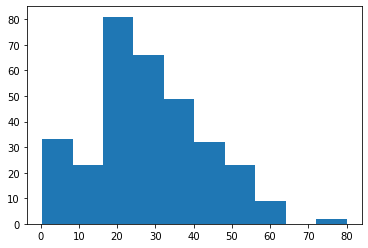

In [79]:
plt.hist(data[ data['survived']==1 ]['age'])

# Модель на основе числовых признаков

## Удаление строк с пропусками

В качестве базовой модели имеет смысл построить модель с минимальными трудозатратами.

Из исходного датасета удалите все категориальные признаки, а также строки, содержащие пропуски.

При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки<b> с параметрами, указанными в вашем задании</b>. Используйте стратификацию по колонке <code>survived</code>.

Обучите модель <code>LogisticRegression()</code> <b>с параметрами, указанными в вашем задании</b>, на тренировочных данных, оцените на тестовых.

Вычислите <code>f1_score</code> модели на тестовых данных (рекомендуем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">соответствующую функцию</a> с параметрами по умолчанию.



In [80]:
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns

In [81]:
df_del = data[numerical_features].dropna()
df_del.head()

,pclass,survived,age,fare,fam_size
2,3,1,38.0,7.2292,0
3,3,0,22.0,7.8958,0
4,3,0,16.0,9.5000,0
5,3,1,29.0,7.7500,0
7,1,0,25.0,26.0000,0


In [82]:
X = df_del.drop('survived', axis=1)
y = df_del['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41, stratify=y)

In [83]:
model = LogisticRegression(random_state=41, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=41)

In [84]:
y_pred = model.predict(X_test)
f1_score(y_test, y_pred)

0.5565217391304348

## Заполнение пропусков средним

Качество полученной модели оставляет желать лучшего. Имеет смысл попробовать заполнить пропуски. Из исходного набора данных удалите категориальные признаки, а пропуски заполните средним по столбцу. Далее аналогично: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [85]:
df_fill_mean = data[numerical_features].fillna(data[numerical_features].mean())

In [86]:
X = df_fill_mean.drop('survived', axis=1)
y = df_fill_mean['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41, stratify=y)

In [87]:
model = LogisticRegression(random_state=41, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=41)

In [88]:
y_pred = model.predict(X_test)
f1_score(y_test, y_pred)

0.481203007518797

## Заполнение пропусков на основе обращения


Очевидно, что заполнение пропусков в колонке <code>age</code> средним — не самая разумная идея. Возможно, стоит выполнить эту процедуру как-то более интеллектуально, например, с оглядкой на обращение к человеку. 

Можно заметить, что исходный датасет в столбце <code>name</code> содержит информацию о социальном статусе пассажира, а именно присутсвуют обращения <code>Mr., Mrs., Dr.</code> и т.д. На основе этой информации можно попробовать сделать предположение о возрасте пассажира.

Верните в рассмотрение колонку <code>name</code>. Создайте отдельную колонку <code>honorific</code> и поместите туда значения обращений.

Вычислите число уникальных обращений.

In [89]:
df = data[numerical_features]
df['name'] = data['name'].copy()
df.head()

/tmp/ipykernel_9699/4278296716.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['name'] = data['name'].copy()


,pclass,survived,age,fare,fam_size,name
0,3,1,NaN,7.7333,0,"Smyth, Miss. Julia"
1,3,1,NaN,7.7500,0,"Glynn, Miss. Mary Agatha"
2,3,1,38.0,7.2292,0,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)"
3,3,0,22.0,7.8958,0,"Vovk, Mr. Janko"
4,3,0,16.0,9.5000,0,"de Pelsmaeker, Mr. Alfons"


In [90]:
df['honorific'] = df['name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

/tmp/ipykernel_9699/115056986.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['honorific'] = df['name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())


In [91]:
df.head()

,pclass,survived,age,fare,fam_size,name,honorific
0,3,1,NaN,7.7333,0,"Smyth, Miss. Julia",Miss
1,3,1,NaN,7.7500,0,"Glynn, Miss. Mary Agatha",Miss
2,3,1,38.0,7.2292,0,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",Mrs
3,3,0,22.0,7.8958,0,"Vovk, Mr. Janko",Mr
4,3,0,16.0,9.5000,0,"de Pelsmaeker, Mr. Alfons",Mr


In [92]:
df['honorific'].value_counts()

honorific
Mr              572
Miss            194
Mrs             145
Master           46
Rev               6
Dr                6
Col               3
Mlle              2
Ms                2
Dona              1
the Countess      1
Major             1
Don               1
Capt              1
Name: count, dtype: int64

In [93]:
df['honorific'].value_counts().shape

(14,)

Скорее всего имеет смысл сократить число обращений, добавив малочисленные группы к более многочисленным, так как принципиальной разницы между, например, <code>Don</code> и <code>Mr</code>, видимо, нет. Отметим, что <code>Master</code> — это прежнее обращение к ребенку, с этим обращением будем работать отдельно.




Выполните следующие замены:

<code>Mr</code> $\leftarrow$ <code>['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt']</code>

<code>Mrs</code> $\leftarrow$ <code> ['Dona', 'Countess']</code>

<code>Miss</code> $\leftarrow$ <code> ['Mlle', 'Ms']</code>

In [94]:
df.loc[ df['honorific'] == 'Rev', 'honorific'] = 'Mr'
df.loc[ df['honorific'] == 'Col', 'honorific'] = 'Mr'
df.loc[ df['honorific'] == 'Dr', 'honorific'] = 'Mr'
df.loc[ df['honorific'] == 'Major', 'honorific'] = 'Mr'
df.loc[ df['honorific'] == 'Don', 'honorific'] = 'Mr'
df.loc[ df['honorific'] == 'Capt', 'honorific'] = 'Mr'

df.loc[ df['honorific'] == 'Dona', 'honorific'] = 'Mrs'
df.loc[ df['honorific'] == 'the Countess', 'honorific'] = 'Mrs'

df.loc[ df['honorific'] == 'Mlle', 'honorific'] = 'Miss'
df.loc[ df['honorific'] == 'Ms', 'honorific'] = 'Miss'

In [95]:
df['honorific'].value_counts()

honorific
Mr        590
Miss      198
Mrs       147
Master     46
Name: count, dtype: int64

Вычислите долю строк со значением <code>Master</code> относительно числа всех мужчин

In [96]:
num_master = df.loc[df['honorific'] == 'Master'].shape[0]
ratio_master_male = num_master/num_male
print(ratio_master_male)

0.07232704402515723


Вычислите средний возраст категории, указанной в вашем индивидуальном задании

In [97]:
df.loc[ df['honorific'] == 'Miss', 'age' ].mean()

22.00576540880503

Заполните пропуски в колонке <code>age</code> средним, соответствующим среднему категории <code>honorific</code>.

Избавьтесь от нечисловых признаков. Далее аналогично: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [98]:
# replace age with mean of honorific
for honorific in ['Mr', 'Mrs', 'Miss', 'Master']:
    mean = df.loc[ df['honorific'] == honorific, 'age' ].mean()
    df.loc[ df['age'].isna() & (df['honorific'] == honorific), 'age' ] = mean

In [99]:
df.drop(['honorific', 'name'], axis=1, inplace=True)

/tmp/ipykernel_9699/2829819493.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['honorific', 'name'], axis=1, inplace=True)


In [100]:
df.head()

,pclass,survived,age,fare,fam_size
0,3,1,22.005765,7.7333,0
1,3,1,22.005765,7.7500,0
2,3,1,38.000000,7.2292,0
3,3,0,22.000000,7.8958,0
4,3,0,16.000000,9.5000,0


In [101]:
X = df.drop('survived', axis=1)
y = df['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41, stratify=y)

In [102]:
model = LogisticRegression(random_state=41, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=41)

In [103]:
y_pred = model.predict(X_test)
f1_score(y_test, y_pred)

0.48484848484848486

# Модель с использование категориальных признаков

В исходном наборе данных заполните пропуски колонки <code>age</code> значениями на основе обращений (как в предыдущем пункте).

Не используйте признаки <code>name</code> и <code>honorific</code>. Они свою функцию выполнили.

Произведите <code>one-hot</code> кодировние нечисловых признаков, например, с помощью <code>pd.get_dummies(drop_first=True)</code>. Далее по знакомой схеме: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [104]:
df = data.copy()

df.head()

,pclass,survived,name,sex,age,fare,embarked,fam_size
0,3,1,"Smyth, Miss. Julia",female,NaN,7.7333,Q,0
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,7.7500,Q,0
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,7.2292,C,0
3,3,0,"Vovk, Mr. Janko",male,22.0,7.8958,S,0
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,9.5000,S,0


In [105]:
df['honorific'] = df['name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [106]:
df.loc[ df['honorific'] == 'Rev', 'honorific'] = 'Mr'
df.loc[ df['honorific'] == 'Col', 'honorific'] = 'Mr'
df.loc[ df['honorific'] == 'Dr', 'honorific'] = 'Mr'
df.loc[ df['honorific'] == 'Major', 'honorific'] = 'Mr'
df.loc[ df['honorific'] == 'Don', 'honorific'] = 'Mr'
df.loc[ df['honorific'] == 'Capt', 'honorific'] = 'Mr'

df.loc[ df['honorific'] == 'Dona', 'honorific'] = 'Mrs'
df.loc[ df['honorific'] == 'the Countess', 'honorific'] = 'Mrs'

df.loc[ df['honorific'] == 'Mlle', 'honorific'] = 'Miss'
df.loc[ df['honorific'] == 'Ms', 'honorific'] = 'Miss'

In [107]:
# replace age with mean of honorific
for honorific in ['Mr', 'Mrs', 'Miss', 'Master']:
    mean = df.loc[ df['honorific'] == honorific, 'age' ].mean()
    df.loc[ df['age'].isna() & (df['honorific'] == honorific), 'age' ] = mean

In [108]:
df.drop(['honorific', 'name'], axis=1, inplace=True)
df = pd.get_dummies(df, drop_first=True)

In [109]:
df.head()

,pclass,survived,age,fare,fam_size,sex_male,embarked_Q,embarked_S
0,3,1,22.005765,7.7333,0,False,True,False
1,3,1,22.005765,7.7500,0,False,True,False
2,3,1,38.000000,7.2292,0,False,False,False
3,3,0,22.000000,7.8958,0,True,False,True
4,3,0,16.000000,9.5000,0,True,False,True


In [110]:
X = df.drop('survived', axis=1)
y = df['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41, stratify=y)

In [111]:
model = LogisticRegression(random_state=41, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=41)

In [112]:
y_pred = model.predict(X_test)
f1_score(y_test, y_pred)

0.676056338028169

# Reserved data

In [113]:
data = pd.read_csv('titanic_reserved.csv')

In [114]:
data['fam_size'] = data['sibsp'] + data['parch']
data.drop('sibsp', axis=1, inplace=True)
data.drop('parch', axis=1, inplace=True)
data

,pclass,name,sex,age,ticket,fare,cabin,embarked,home.dest,fam_size
0,3,"Sage, Mr. Frederick",male,NaN,CA. 2343,69.5500,NaN,S,NaN,10
1,1,"Snyder, Mr. John Pillsbury",male,24.0000,21228,82.2667,B45,S,"Minneapolis, MN",1
2,2,"Ashby, Mr. John",male,57.0000,244346,13.0000,NaN,S,"West Hoboken, NJ",0
3,3,"Rosblom, Mr. Viktor Richard",male,18.0000,370129,20.2125,NaN,S,NaN,2
4,2,"Doling, Miss. Elsie",female,18.0000,231919,23.0000,NaN,S,Southampton,1
...,...,...,...,...,...,...,...,...,...,...
323,1,"Brewe, Dr. Arthur Jackson",male,NaN,112379,39.6000,NaN,C,"Philadelphia, PA",0
324,1,"Romaine, Mr. Charles Hallace (""Mr C Rolmane"")",male,45.0000,111428,26.5500,NaN,S,"New York, NY",0
325,1,"Meyer, Mrs. Edgar Joseph (Leila Saks)",female,NaN,PC 17604,82.1708,NaN,C,"New York, NY",1
326,2,"Caldwell, Master. Alden Gates",male,0.8333,248738,29.0000,NaN,S,"Bangkok, Thailand / Roseville, IL",2


In [115]:
df = data[numerical_features.copy().drop('survived')]
df['name'] = data['name'].copy()
df['embarked'] = data['embarked'].copy()
df['sex'] = data['sex'].copy()
# df = data
df.head()

/tmp/ipykernel_9699/1214341393.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['name'] = data['name'].copy()
/tmp/ipykernel_9699/1214341393.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['embarked'] = data['embarked'].copy()
/tmp/ipykernel_9699/1214341393.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

,pclass,age,fare,fam_size,name,embarked,sex
0,3,NaN,69.5500,10,"Sage, Mr. Frederick",S,male
1,1,24.0,82.2667,1,"Snyder, Mr. John Pillsbury",S,male
2,2,57.0,13.0000,0,"Ashby, Mr. John",S,male
3,3,18.0,20.2125,2,"Rosblom, Mr. Viktor Richard",S,male
4,2,18.0,23.0000,1,"Doling, Miss. Elsie",S,female


In [116]:
df['honorific'] = df['name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

/tmp/ipykernel_9699/115056986.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['honorific'] = df['name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())


In [117]:
df.loc[ df['honorific'] == 'Rev', 'honorific'] = 'Mr'
df.loc[ df['honorific'] == 'Col', 'honorific'] = 'Mr'
df.loc[ df['honorific'] == 'Dr', 'honorific'] = 'Mr'
df.loc[ df['honorific'] == 'Major', 'honorific'] = 'Mr'
df.loc[ df['honorific'] == 'Don', 'honorific'] = 'Mr'
df.loc[ df['honorific'] == 'Capt', 'honorific'] = 'Mr'

df.loc[ df['honorific'] == 'Dona', 'honorific'] = 'Mrs'
df.loc[ df['honorific'] == 'the Countess', 'honorific'] = 'Mrs'

df.loc[ df['honorific'] == 'Mlle', 'honorific'] = 'Miss'
df.loc[ df['honorific'] == 'Ms', 'honorific'] = 'Miss'

In [118]:
# replace age with mean of honorific
for honorific in ['Mr', 'Mrs', 'Miss', 'Master']:
    mean = df.loc[ df['honorific'] == honorific, 'age' ].mean()
    df.loc[ df['age'].isna() & (df['honorific'] == honorific), 'age' ] = mean

In [119]:
df.drop(['honorific', 'name'], axis=1, inplace=True)
df = pd.get_dummies(df, drop_first=True)

/tmp/ipykernel_9699/206756299.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['honorific', 'name'], axis=1, inplace=True)


In [120]:
# df.drop(['honorific', 'name'], axis=1, inplace=True)

In [121]:
X = df

In [122]:
X =  X.reindex(columns=X_train.columns)

In [123]:
X.head()

,pclass,age,fare,fam_size,sex_male,embarked_Q,embarked_S
0,3,32.387755,69.5500,10,True,False,True
1,1,24.000000,82.2667,1,True,False,True
2,2,57.000000,13.0000,0,True,False,True
3,3,18.000000,20.2125,2,True,False,True
4,2,18.000000,23.0000,1,False,False,True


In [124]:
y_pred = model.predict(X)
# f1_score(y_test, y_pred)

In [126]:
# write y_pred to file
y_pred = pd.DataFrame(y_pred, columns=['label'])
y_pred.T.to_csv('y_pred.csv', index=False, header=False)